In [99]:
# Imports 
import os
# Important: insert the path to synaptic_plasticity/src
os.chdir('\SynologyDrive\Downloads\synaptic_plasticity-separated_data_loading(1)\synaptic_plasticity-separated_data_loading\src')
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import spikingjelly
import utils
import network
from spikingjelly.activation_based import functional

## Loading a random MNIST image

In [100]:
transform = transforms.Compose([transforms.ToTensor()])
mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist, batch_size=1, shuffle=True)

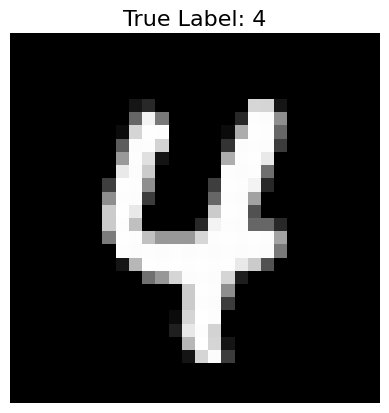

In [101]:
# Select a random sample
sample_idx = random.randint(0, len(mnist) - 1)
sample, label = mnist[sample_idx]

# Visualize the sample
plt.imshow(sample.squeeze(), cmap='gray')
plt.axis('off')
plt.title(f"True Label: {label}")
plt.show()

## Encoding static image into spike trains

In [102]:
_, testing_loader = utils.load_MNIST()
encoded, encoded_label = testing_loader.dataset[sample_idx]

0


In [103]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
from IPython.display import HTML

# Sample tensor data (replace this with your actual tensor)
data = encoded  # Shape: [15, 6, 28, 28]

# Convert to numpy array for plotting
data_np = data.numpy()

# Create a figure and subplots
fig, axs = plt.subplots(1, 6, figsize=(18, 3))
fig.patch.set_facecolor('lightsalmon')

# Hide the axes for a cleaner display
for ax in axs:
    ax.axis('off')

# Animation update function
def update(t):
    for i, ax in enumerate(axs):
        ax.imshow(data_np[t, i], cmap='grey')
        ax.set_title(f'Channel = {i}', color='white', fontsize=10, fontweight='bold')
    return axs

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=15, interval=200, blit=False)

# Close the figure to prevent the initial plot from showing
plt.close(fig)

# Display the animation
HTML(ani.to_jshtml())


## Insert the encoded MNIST sample into the model

In [104]:
net = network.Network(number_of_classes=10)

(-0.5, 4.5, 4.5, -0.5)

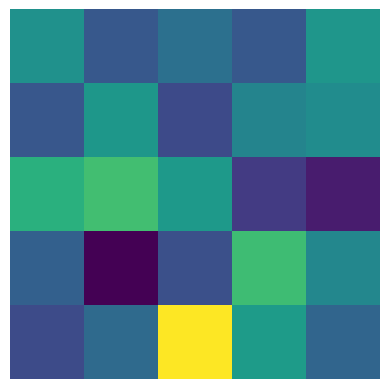

In [105]:
plt.imshow(net.conv1.weight.detach().numpy()[0,0])
plt.axis('off')

In [106]:
latest_checkpoint_path = utils.get_latest_checkpoint('../checkpoints/experiment_1')
if latest_checkpoint_path:
    # Load the checkpoint if found
    start_epoch, training_layer = utils.load_checkpoint(net,
                                                    latest_checkpoint_path)

Latest checkpoint found: checkpoint_20240829-082540_epoch_39.pth
Checkpoint loaded: epoch 40, training layer 3.


(-0.5, 4.5, 4.5, -0.5)

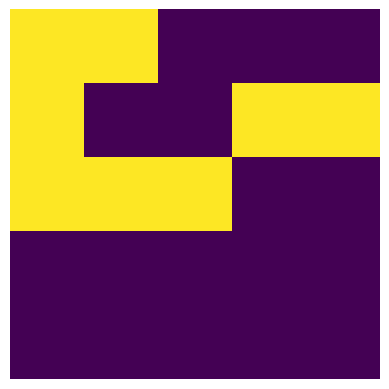

In [107]:
plt.imshow(net.conv1.weight.detach().numpy()[0,0])
plt.axis('off')

In [108]:
encoded_label

4

In [109]:
# Use multistep mode for faster training
functional.set_step_mode(net, step_mode='m')
frame = encoded.to('cpu:0')
frame = frame.unsqueeze(dim=0)
frame = frame.transpose(0, 1)
frame = frame.float()
_ = net(frame)

In [110]:
# Extract the decision value as an integer
decision = net.get_decision()
decision_value = int(decision.numpy()[0])

# Determine if the decision is correct
result = "Correct 😀" if decision_value == label else "Incorrect 😭"

# Print the result
print(f"The network decided: {decision_value}\nThe true label: {label}\n{result}")

The network decided: 4
The true label: 4
Correct 😀


## Loading a random N-MNIST sample

In [116]:
import tonic
from torch.utils.data import DataLoader

# Load the N-MNIST dataset
n_mnist = tonic.datasets.NMNIST(save_to='./data_n_mnist', train=True)
# Create DataLoader for training and testing
n_mnist_loader = DataLoader(n_mnist, batch_size=100, shuffle=True)

Sample Index: 10901, Label: 1


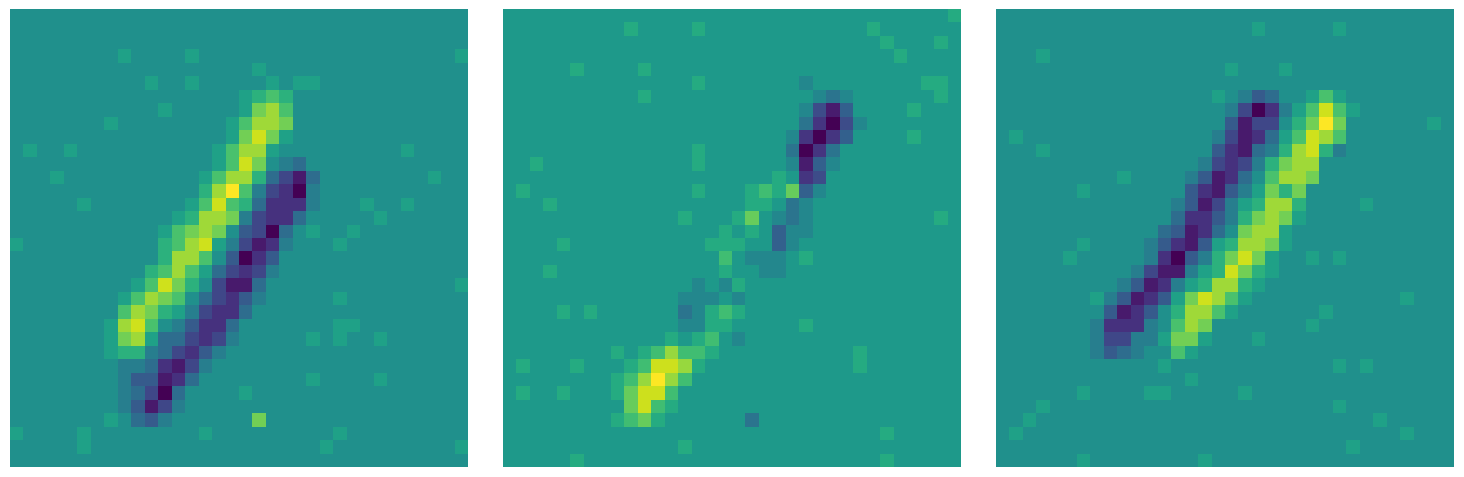

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import tonic.transforms as transforms
import random

# Define the transform
sensor_size = tonic.datasets.NMNIST.sensor_size
frame_transform = transforms.ToFrame(sensor_size=sensor_size, n_time_bins=3)

# Select a random sample
sample_idx = random.randint(0, len(n_mnist) - 1)
sample_spiking, label_spiking = n_mnist[sample_idx]
# Debugging: Print sample index and label
print(f"Sample Index: {sample_idx}, Label: {label_spiking}")

# Apply the transform to the sample
def apply_transform(events, transform):
    frames = transform(events)
    return frames

frames = apply_transform(sample_spiking, frame_transform)

# Function to plot frames
def plot_frames(frames):
    num_frames = len(frames)
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))

    if num_frames == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one frame

    for axis, frame in zip(axes, frames):
        # Subtract the ON and OFF polarities to get the difference
        # Assuming the shape of frame is (Time, Number of polarities, Height, Width)
        frame_diff = frame[1] - frame[0]  # Difference between polarities
        axis.imshow(frame_diff)
        axis.axis("off")


    plt.tight_layout()
    plt.show()

# Plot the original frames
plot_frames(frames)

## Encode Spike traces

In [160]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

data_np = np.stack(frames)

# Check the number of frames available
num_frames = data_np.shape[0]  # Assuming data_np has shape (num_frames, channels, height, width)

# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))  # 2 channels (ON/OFF)
fig.patch.set_facecolor('lightsalmon')

# Hide the axes for a cleaner display
for ax in axs:
    ax.axis('off')

# Animation update function
def update(t):
    for i, ax in enumerate(axs):
        ax.imshow(data_np[t, i], cmap='gray')  # Show the ON and OFF channels separately
        ax.set_title(f'Channel = {i}', color='white', fontsize=10, fontweight='bold')
    return axs

# Adjust the number of frames to be within the bounds of available frames
num_frames_to_show = min(15, num_frames)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=num_frames_to_show, interval=200, blit=False)

# Close the figure to prevent the initial plot from showing
plt.close(fig)

# Display the animation
HTML(ani.to_jshtml())




## Insert the encoded N-MNIST sample into the model

In [141]:
#import network_two_channels
net = network.Network(input_channels=2, number_of_classes=10)

In [142]:
latest_checkpoint_path = utils.get_latest_checkpoint('../checkpoints/experiment_2')
if latest_checkpoint_path:
    # Load the checkpoint if found
    start_epoch, training_layer = utils.load_checkpoint(net,
                                                    latest_checkpoint_path)

Latest checkpoint found: checkpoint_20240831-080532_epoch_20.pth
Checkpoint loaded: epoch 21, training layer 3.


(-0.5, 4.5, 4.5, -0.5)

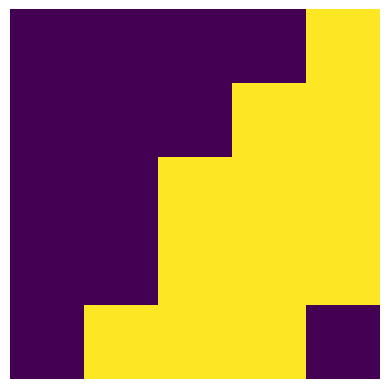

In [143]:
plt.imshow(net.conv1.weight.detach().numpy()[0,0])
plt.axis('off')

In [172]:
# Check the shape of the frames
print(f"Frames shape: {frames.shape}")

# Convert the NumPy array to a PyTorch tensor
#frames_tensor = torch.from_numpy(frames)
#frames_tensor = frames_tensor.unsqueeze(0)
#frames_tensor = frames_tensor.float()

print(f"Frames shape: {frames_tensor.shape}")
# Perform a forward pass
with torch.no_grad():  # Disable gradient computation
    outputs = net(frames_tensor)  # Use net(frames_tensor) instead of net.forward(frames_tensor)



# Extract the decision value as an integer
decision_value = net.get_decision()

# Determine if the decision is correct
result = "Correct 😀" if decision_value == label else "Incorrect 😭"

# Print the result
print(f"The network decided: {decision_value}\nThe true label: {label}\n{result}")



Frames shape: (3, 2, 34, 34)
Frames shape: torch.Size([3, 2, 34, 34])


RuntimeError: Input type (short) and bias type (float) should be the same

## Final plot summarizing the training and testing accuracies of the experimental runs

![alt text](../photo_2024-08-31_11-07-50.jpg)